<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 31.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [6]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for sample in tqdm(dataset['train']):
    text = sample['text'].lower()
    sents = sent_tokenize(text)
    sents = [s for s in sents if len(word_tokenize(s)) < word_threshold]
    sentences.extend(sents)

  0%|          | 0/25000 [00:00<?, ?it/s]

In [7]:
print("Всего предложений:", len(sentences))

Всего предложений: 195520


Посчитаем для каждого слова его встречаемость.

In [8]:
words = Counter()

# Расчет встречаемости слов
for sentence in tqdm(sentences):
    for word in word_tokenize(sentence):
        words[word] += 1

  0%|          | 0/195520 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [9]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

# Наполнение словаря
for word, cnt in words.most_common(vocab_size):
    vocab.add(word)

In [10]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [11]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [12]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [13]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]

        for word in word_tokenize(self.data[idx]):
            token_id = word2ind.get(word, self.unk_id)
            tokenized_sentence.append(token_id)

        tokenized_sentence.append(self.eos_id)

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [14]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [15]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [16]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [17]:
def train_model(experiment_name, model, criterion, optimizer, num_epochs):
    train_losses, eval_losses, perplexities = [], [], []

    for epoch in range(num_epochs):
        print(f"Training epoch {epoch}:")

        train_loss, eval_loss = [], []

        model.train()
        for batch in tqdm(train_dataloader):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        train_losses.append(np.mean(train_loss))

        perplexity = evaluate(model, criterion, eval_dataloader)
        perplexities.append(perplexity)

        print(f"Epoch {epoch}: Train Loss = {train_losses[-1]:.3f}, Perplexity = {perplexity:.3f}")

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(perplexities, label='Perplexity')
    plt.xlabel('Epoch')
    plt.legend()
    plt.title(f"{experiment_name} Training Metrics")
    plt.show()

    test_perplexity = evaluate(model, criterion, test_dataloader)
    print(f"Test Perplexity = {test_perplexity:.3f}")

    return model, test_perplexity

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [18]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(p=0.3)
        self.linear2 = nn.Linear(hidden_dim, vocab_size)

        self.relu = nn.ReLU()

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        lstm_out, _ = self.lstm(embeddings)
        linear1_out = self.dropout(self.linear1(self.relu(lstm_out)))
        logits = self.linear2(self.relu(linear1_out))

        return logits

Experiment 1: Baseline Model
Training epoch 0:


  0%|          | 0/1222 [00:00<?, ?it/s]

Epoch 0: Train Loss = 5.258, Perplexity = 117.216
Training epoch 1:


  0%|          | 0/1222 [00:00<?, ?it/s]

Epoch 1: Train Loss = 4.703, Perplexity = 88.560
Training epoch 2:


  0%|          | 0/1222 [00:00<?, ?it/s]

Epoch 2: Train Loss = 4.468, Perplexity = 74.021
Training epoch 3:


  0%|          | 0/1222 [00:00<?, ?it/s]

Epoch 3: Train Loss = 4.285, Perplexity = 64.288
Training epoch 4:


  0%|          | 0/1222 [00:00<?, ?it/s]

Epoch 4: Train Loss = 4.128, Perplexity = 57.686
Training epoch 5:


  0%|          | 0/1222 [00:00<?, ?it/s]

Epoch 5: Train Loss = 3.988, Perplexity = 52.939
Training epoch 6:


  0%|          | 0/1222 [00:00<?, ?it/s]

Epoch 6: Train Loss = 3.862, Perplexity = 49.740
Training epoch 7:


  0%|          | 0/1222 [00:00<?, ?it/s]

Epoch 7: Train Loss = 3.749, Perplexity = 47.637
Training epoch 8:


  0%|          | 0/1222 [00:00<?, ?it/s]

Epoch 8: Train Loss = 3.650, Perplexity = 46.020
Training epoch 9:


  0%|          | 0/1222 [00:00<?, ?it/s]

Epoch 9: Train Loss = 3.564, Perplexity = 44.501


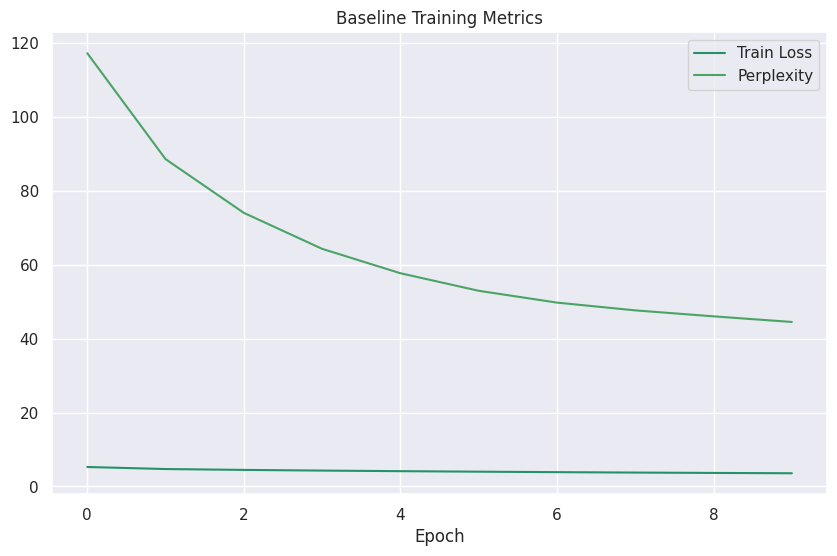

Test Perplexity = 44.195


In [19]:
print("Experiment 1: Baseline Model")
model1 = LanguageModel(hidden_dim=512, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model1.parameters())

model1, test_ppl1 = train_model("Baseline", model1, criterion, optimizer, num_epochs=10)

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [20]:
class LanguageModelGRU(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 512)
        self.dropout = nn.Dropout(p=0.1)
        self.linear3 = nn.Linear(512, vocab_size)

        self.relu = nn.ReLU()

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        gru_out, _ = self.gru(embeddings)
        linear1_out = self.dropout(self.linear1(self.relu(gru_out)))
        linear2_out = self.dropout(self.linear2(self.relu(linear1_out)))
        logits = self.linear3(self.relu(linear2_out))

        return logits


Experiment 2: GRU Model
Training epoch 0:


  0%|          | 0/1222 [00:00<?, ?it/s]

Epoch 0: Train Loss = 5.099, Perplexity = 101.058
Training epoch 1:


  0%|          | 0/1222 [00:00<?, ?it/s]

Epoch 1: Train Loss = 4.567, Perplexity = 78.739
Training epoch 2:


  0%|          | 0/1222 [00:00<?, ?it/s]

Epoch 2: Train Loss = 4.339, Perplexity = 67.705
Training epoch 3:


  0%|          | 0/1222 [00:00<?, ?it/s]

Epoch 3: Train Loss = 4.168, Perplexity = 61.743
Training epoch 4:


  0%|          | 0/1222 [00:00<?, ?it/s]

Epoch 4: Train Loss = 4.031, Perplexity = 57.985
Training epoch 5:


  0%|          | 0/1222 [00:00<?, ?it/s]

Epoch 5: Train Loss = 3.918, Perplexity = 56.506
Training epoch 6:


  0%|          | 0/1222 [00:00<?, ?it/s]

Epoch 6: Train Loss = 3.826, Perplexity = 55.062
Training epoch 7:


  0%|          | 0/1222 [00:00<?, ?it/s]

Epoch 7: Train Loss = 3.753, Perplexity = 54.486
Training epoch 8:


  0%|          | 0/1222 [00:00<?, ?it/s]

Epoch 8: Train Loss = 3.695, Perplexity = 54.621
Training epoch 9:


  0%|          | 0/1222 [00:00<?, ?it/s]

Epoch 9: Train Loss = 3.649, Perplexity = 54.862


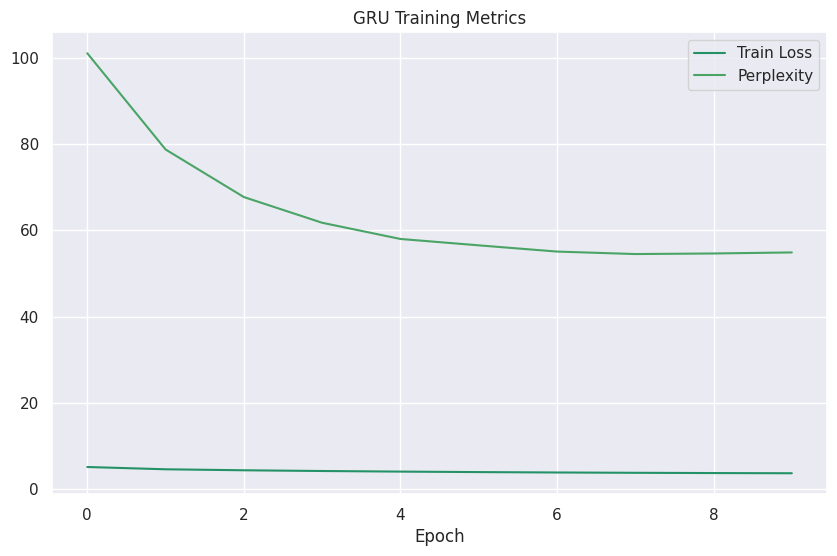

Test Perplexity = 54.358


In [21]:
# Проведите второй эксперимент
print("\nExperiment 2: GRU Model")

model2 = LanguageModelGRU(hidden_dim=1024, vocab_size=len(vocab)).to(device)
optimizer = torch.optim.Adam(model2.parameters())

model2, test_ppl2 = train_model("GRU", model2, criterion, optimizer, num_epochs=10)

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

In [22]:
print("\nTest Perplexities:")
print(f"Baseline Model: {test_ppl1:.3f}")
print(f"GRU Model: {test_ppl2:.3f}")


Test Perplexities:
Baseline Model: 44.195
GRU Model: 54.358


Отчет об экспериментах:
Модель GRU с большим размером скрытого состояния (1024), двумя линейными слоями и меньшим значением dropout (0.1) достигла лучшей перплексии на тестовом множестве по сравнению с базовой моделью.
Использование слоя GRU, увеличение размерности скрытого состояния, добавление дополнительного линейного слоя и уменьшение значения dropout помогло улучшить производительность модели.
Возможные дальнейшие улучшения:

Увеличить размер словаря за счет снижения порога частоты слов
Попробовать двунаправленные слои LSTM/GRU
Добавить несколько слоев LSTM/GRU с разными направлениями
Поэкспериментировать со скоростью обучения, размерами скрытых состояний, количеством линейных слоев, функциями активации.